# File IO Testing

TEPs-I involves creating and reading large numbers of files in array-like format to disk in order to move files from one process to the next.  For 2011, there are 1300 output files from PECOUNT, ranging from 300 (15 KB) to 34000 (1.8 MB) rows of data totalling arond 100 MB of plain text files.

We need to find a way of efficiently reading, writing to and storing 2 million x 5 rows of data.

All tests below were done using a desktop with an Intel Core i5 and 16 GB of RAM.

In [115]:
# Preamble
%matplotlib notebook
import os
import numpy as np
import pandas as pd
import h5py
import joblib
import dask.dataframe as dd
import time
import tables
import multiprocessing as multi
import pickle
import matplotlib.pyplot as plt

In [2]:
# Tiny timeit wrapper.
import timeit

def mytimeit(source, number=1):
    """Wrapper around `timeit.timeit` to run some source code using the
    current namespace.  For file writing, set number=1!"""
    return timeit.timeit(source, globals=globals(), number=number)

## Read Arman's PECOUNT-II Output

In [3]:
# Read in Arman's 20050591_17636_2011.txt.
raw_data = pd.read_csv('./20050591_17636_2011.txt', sep='\t', header=None,
                       parse_dates=[3,])
raw_data.columns = ['Nonsense', 'Centreline ID', 'Direction',
                    'Timestamp', 'Count', 'Something']

raw_data.head()

,Nonsense,Centreline ID,Direction,Timestamp,Count,Something
0,192280:65824385,20050591,-1,2011-01-01 00:00:00,37,1
1,192281:65824386,20050591,-1,2011-01-01 00:15:00,36,1
2,192282:65824387,20050591,-1,2011-01-01 00:30:00,53,1
3,192283:65824388,20050591,-1,2011-01-01 00:45:00,66,1
4,192284:65824389,20050591,-1,2011-01-01 01:00:00,52,1


In [4]:
# May be much more efficient to store timestamps as floats (certainly takes less
# time to read in!)
raw_data['Timedelta_hr'] = ((raw_data['Timestamp'] - raw_data['Timestamp'][0]) /
                            np.timedelta64(1, 'h'))

In [5]:
# Are zero counts in 15 min properly recorded?
raw_data['Count'].value_counts().sort_index().head()

0      6
1     29
2    106
3    228
4    350
Name: Count, dtype: int64

`STTC_estimate3.m` appears to only use the timestamp and count.  Let us save only these values (I have no idea what the first and last columns are even for, and the ID and direction can be stored as metadata or in the name.

## File I/O Prototypes

For now, keep timestamps as timestamps.

### Baseline - output to CSV

In [6]:
# Output to file
csv_output_source = """for i in range(100):
    raw_data[["Timestamp", "Count"]].to_csv("temptemp_{0:03d}.csv".format(i))
"""

print("Writing 100 two-column files to disk takes {0:.3f} s."
      .format(mytimeit(csv_output_source)))

Writing 100 two-column files to disk takes 8.571 s.


In [7]:
print("Size of files on disk: {0:.2f} MB"
      .format(100 * os.path.getsize("temptemp_000.csv") / 1024.**2))

Size of files on disk: 95.07 MB


In [8]:
# Read files
csv_input_source = """for i in range(100):
    new_data = pd.read_csv("temptemp_{0:03d}.csv".format(i), parse_dates=[0,])
"""

print("Reading 100 files from disk takes {0:.3f} s."
      .format(mytimeit(csv_input_source)))

Reading 100 files from disk takes 2.724 s.


In [9]:
os_del_success = os.system('rm ./temptemp*.csv')

### Pandas write to tabular HDF5 - multi-file

In [10]:
# Output to file
pandas_hdf_output_source = """for i in range(100):
    (raw_data[["Timestamp", "Count"]]
     .to_hdf("temptemp_{0:03d}.hdf".format(i), "table"))
"""

print("Writing 100 two-column files to disk takes {0:.3f} s."
      .format(mytimeit(pandas_hdf_output_source)))

Writing 100 two-column files to disk takes 0.719 s.


In [11]:
print("Size of files on disk: {0:.2f} MB"
      .format(100 * os.path.getsize("temptemp_000.hdf") / 1024.**2))

Size of files on disk: 79.08 MB


In [12]:
# Read files
pandas_hdf_input_source = """for i in range(100):
    new_data = pd.read_hdf("temptemp_{0:03d}.hdf".format(i), key="table", parse_dates=[0,])
"""

print("Reading 100 files from disk takes {0:.3f} s."
      .format(mytimeit(pandas_hdf_input_source)))

Reading 100 files from disk takes 0.545 s.


In [13]:
os_del_success = os.system('rm ./temptemp*.hdf')

### Pandas write to tabular HDF5 - single file

In [14]:
pandas_hdf_single_output_source = """for i in range(100):
    (raw_data[["Timestamp", "Count"]]
     .to_hdf("temptemp.hdf", "table_{0:03d}".format(i)))
"""

print("Writing single file with 100 tables to disk takes {0:.3f} s."
      .format(mytimeit(pandas_hdf_single_output_source)))

Writing single file with 100 tables to disk takes 0.859 s.


In [15]:
print("Size of file on disk: {0:.2f} MB"
      .format(os.path.getsize("temptemp.hdf") / 1024.**2))

Size of file on disk: 78.88 MB


In [16]:
# Read files
pandas_hdf_input_source = """for i in range(100):
    new_data = pd.read_hdf("temptemp.hdf", key="table_{0:03d}".format(i), parse_dates=[0,])
"""

print("Reading file from disk takes {0:.3f} s."
      .format(mytimeit(pandas_hdf_input_source)))

Reading file from disk takes 0.622 s.


In [17]:
os_del_success = os.system('rm ./temptemp.hdf')

### Dask write to tabular HDF5 - multi-file

In [18]:
dask_data = dd.from_pandas(raw_data, npartitions=1)

In [19]:
dask_data.loc[0:10, ['Timestamp']].compute()

,Timestamp
0,2011-01-01 00:00:00
1,2011-01-01 00:15:00
2,2011-01-01 00:30:00
3,2011-01-01 00:45:00
4,2011-01-01 01:00:00
5,2011-01-01 01:15:00
6,2011-01-01 01:30:00
7,2011-01-01 01:45:00
8,2011-01-01 02:00:00
9,2011-01-01 02:15:00


In [20]:
dask_hdf_output_source = """for i in range(100):
    (dask_data[["Timestamp", "Count"]]
     .to_hdf("temptemp_{0:03d}.hdf".format(i), "table"))
"""

print("Writing 100 files to disk takes {0:.3f} s."
      .format(mytimeit(dask_hdf_output_source)))

Writing 100 files to disk takes 1.667 s.


In [21]:
print("Size of files on disk: {0:.2f} MB"
      .format(100. * os.path.getsize("temptemp_000.hdf") / 1024.**2))

Size of files on disk: 84.34 MB


In [22]:
# Read files as one big file.  The output is incorrect, since
# the 100 files aren't sections of a larger file...
dask_hdf_input_source = """new_data = (
    dd.read_hdf("temptemp*.hdf", key="table"))
"""

print("Reading 100 files from disk into one big file takes {0:.3f} s."
      .format(mytimeit(dask_hdf_input_source)))

Reading 100 files from disk into one big file takes 1.446 s.


In [23]:
os_del_success = os.system('rm ./temptemp*.hdf')

### Dask write to tabular HDF5 - single file

In [24]:
# Keep getting "This HDFStore is not partitionable" when using timeit.timeit, so
# switching to time.

# Based on https://github.com/dask/dask/issues/2755.
start_time = time.process_time()
with pd.HDFStore("temptemp.hdf", mode='w') as fh:
    for i in range(100):
        fh.put("table_{0:03d}".format(i),
               dask_data[["Timestamp", "Count"]].compute(),
               format='table')
end_time = time.process_time()

print("Writing single file with 100 tables to disk takes {0:.3f} s."
      .format(end_time - start_time))

Writing single file with 100 tables to disk takes 1.676 s.


In [25]:
print("Size of file on disk: {0:.2f} MB"
      .format(os.path.getsize("temptemp.hdf") / 1024.**2))

Size of file on disk: 84.22 MB


In [26]:
start_time = time.process_time()
for i in range(100):
    new_data = dd.read_hdf("temptemp.hdf",
                           key="table_{0:03d}".format(i))
end_time = time.process_time()

print("Reading file from disk takes {0:.3f} s."
      .format(end_time - start_time))

Reading file from disk takes 8.076 s.


In [27]:
os_del_success = os.system('rm ./temptemp.hdf')

Kind of feel like Dask isn't the right tool for this job.  Dask DataFrame excels where data is large and spread over multiple files, but have to be reconstructed back to a single massive table.  This isn't the case with us - we often have to analyze a very small section of the data on disk.

### Pandas write to numerical HDF5 - single file

It looks like writing to a single HDF file is generically faster than writing to hundreds of tiny ones, so let's just try that.


In [28]:
pandas_hdf_single_output_source = """for i in range(100):
    (raw_data[["Timedelta_hr", "Count"]]
     .to_hdf("temptemp.hdf", "table_{0:03d}".format(i)))
"""

print("Writing single file with 100 tables to disk takes {0:.3f} s."
      .format(mytimeit(pandas_hdf_single_output_source)))

Writing single file with 100 tables to disk takes 0.935 s.


In [29]:
print("Size of file on disk: {0:.2f} MB"
      .format(os.path.getsize("temptemp.hdf") / 1024.**2))

Size of file on disk: 78.88 MB


In [30]:
# Read files
pandas_hdf_input_source = """for i in range(100):
    new_data = pd.read_hdf("temptemp.hdf", key="table_{0:03d}".format(i), parse_dates=[0,])
"""

print("Reading file from disk takes {0:.3f} s."
      .format(mytimeit(pandas_hdf_input_source)))

Reading file from disk takes 0.694 s.


In [31]:
os_del_success = os.system('rm ./temptemp.hdf')

### PyTables write to numerical HDF5 - single file

Based on the [PyTables tutorial](https://www.pytables.org/usersguide/tutorials.html) it looks like we can only populate tables with row data, not column, which is silly if we have lots of rows and only a handful of columns.  Use their array logic instead.

In [73]:
# Write test
start_time = time.process_time()

with tables.open_file("temptemp.hdf", mode="w", title="File IO test") as fh:
    for i in range(100):
        group = fh.create_group("/", "table_{0:03d}".format(i),
                                "Readout of counter {0:03d}".format(i))
        group._v_attrs.start_time = str(raw_data.loc[0, 'Timestamp'])
        group._v_attrs.centreline_id = raw_data.loc[0, 'Centreline ID']
        group._v_attrs.direction = raw_data.loc[0, 'Direction']
        # Apparently we don't have to specify a dtype; it's auto-detected!
        success = fh.create_array(
            group, 'timedelta', obj=raw_data['Timedelta_hr'].values,
            title="Time in hours from {0}".format(str(raw_data.loc[0, 'Timestamp'])))
        success = fh.create_array(
            group, 'count', obj=raw_data['Count'].values,
            title="Vehicle count".format(str(raw_data.loc[0, 'Timestamp'])))

end_time = time.process_time()

print("Writing 100 two-column files to disk takes {0:.3f} s."
      .format(end_time - start_time))

Writing 100 two-column files to disk takes 0.163 s.


In [74]:
print("Size of file on disk: {0:.2f} MB"
      .format(os.path.getsize("temptemp.hdf") / 1024.**2))

Size of file on disk: 52.35 MB


In [75]:
fh = tables.open_file("temptemp.hdf", "r")
print(fh)

temptemp.hdf (File) 'File IO test'
Last modif.: 'Sun Sep 22 17:35:13 2019'
Object Tree: 
/ (RootGroup) 'File IO test'
/table_000 (Group) 'Readout of counter 000'
/table_000/count (Array(34165,)) 'Vehicle count'
/table_000/timedelta (Array(34165,)) 'Time in hours from 2011-01-01 00:00:00'
/table_001 (Group) 'Readout of counter 001'
/table_001/count (Array(34165,)) 'Vehicle count'
/table_001/timedelta (Array(34165,)) 'Time in hours from 2011-01-01 00:00:00'
/table_002 (Group) 'Readout of counter 002'
/table_002/count (Array(34165,)) 'Vehicle count'
/table_002/timedelta (Array(34165,)) 'Time in hours from 2011-01-01 00:00:00'
/table_003 (Group) 'Readout of counter 003'
/table_003/count (Array(34165,)) 'Vehicle count'
/table_003/timedelta (Array(34165,)) 'Time in hours from 2011-01-01 00:00:00'
/table_004 (Group) 'Readout of counter 004'
/table_004/count (Array(34165,)) 'Vehicle count'
/table_004/timedelta (Array(34165,)) 'Time in hours from 2011-01-01 00:00:00'
/table_005 (Group) 'Readout

In [76]:
list(list(fh.walk_groups("/"))[0])

[/table_000 (Group) 'Readout of counter 000'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_001 (Group) 'Readout of counter 001'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_002 (Group) 'Readout of counter 002'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_003 (Group) 'Readout of counter 003'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_004 (Group) 'Readout of counter 004'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_005 (Group) 'Readout of counter 005'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_006 (Group) 'Readout of counter 006'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_007 (Group) 'Readout of counter 007'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_008 (Group) 'Readout of counter 008'
   children := ['timedelta' (Array), 'count' (Array)],
 /table_009 (Group) 'Readout of counter 009'
   children := ['timedelta' (Array), 'count' (Array)],


In [77]:
fh.root["table_000"]._v_attrs.centreline_id

20050591

In [78]:
fh.close()

In [79]:
start_time = time.process_time()
with tables.open_file("temptemp.hdf", mode="r") as fh:
    for i in range(100):
            timedelta = fh.root["table_{0:03d}".format(i)]['timedelta'].read()
            counts = fh.root["table_{0:03d}".format(i)]['count'].read()
end_time = time.process_time()

print("Reading file from disk takes {0:.3f} s."
      .format(end_time - start_time))

Reading file from disk takes 0.102 s.


In [80]:
os_del_success = os.system('rm ./temptemp.hdf')

### h5py write to numerical hdf5 - single file

In [96]:
start_time = time.process_time()
with h5py.File("temptemp.hdf", 'w', libver='latest') as fh:
    for i in range(100):
        group = fh.create_group("table_{0:03d}".format(i))
        group.attrs['start_time'] = str(raw_data.loc[0, 'Timestamp'])
        group.attrs['centreline_id'] = raw_data.loc[0, 'Centreline ID']
        group.attrs['direction'] = raw_data.loc[0, 'Direction']
        
        ds_timedelta = group.create_dataset('timedelta', (raw_data.shape[0],),
                                            dtype='float64')
        ds_timedelta[:] = raw_data['Timedelta_hr'].values
        ds_count = group.create_dataset('count', (raw_data.shape[0],),
                                        dtype='uint32')
        ds_count[:] = raw_data['Count'].values
end_time = time.process_time()

print("Reading file from disk takes {0:.3f} s."
      .format(end_time - start_time))

Reading file from disk takes 0.195 s.


In [97]:
fh = h5py.File("temptemp.hdf", 'r', libver='latest')

In [98]:
fh['table_000'].attrs['start_time']

'2011-01-01 00:00:00'

In [99]:
fh['table_000']['timedelta'][:]

array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 8.75925e+03,
       8.75950e+03, 8.75975e+03])

In [100]:
fh.close()

In [101]:
start_time = time.process_time()

with h5py.File("temptemp.hdf", 'r', libver='latest') as fh:
    for i in range(100):
        new_timedelta = fh["table_{0:03d}".format(i)]['timedelta'][:]
        new_count = fh["table_{0:03d}".format(i)]['count'][:]

end_time = time.process_time()

print("Reading file from disk takes {0:.3f} s."
      .format(end_time - start_time))

Reading file from disk takes 0.052 s.


In [102]:
# Following
# https://www.machinelearningplus.com/python/parallel-processing-python/#5howtoparallelizeanyfunction

def read_segment_of_file(start, end):
    with h5py.File("temptemp.hdf", 'r', libver='latest') as fh:
        for i in range(start, end):
            new_timedelta = fh["table_{0:03d}".format(i)]['timedelta'][:]
            new_count = fh["table_{0:03d}".format(i)]['count'][:]
    return True

start_time = time.process_time()

pp = multi.Pool(4)
[pp.apply(read_segment_of_file, args=(start, start + 25)) for start in range(0, 100, 25)]

end_time = time.process_time()

print("Reading file from disk using 4 workers takes {0:.3f} s."
      .format(end_time - start_time))

pp.close()

Reading file from disk using 4 workers takes 0.036 s.


In [103]:
os_del_success = os.system('rm ./temptemp.hdf')

### Joblib dump to gzip - multi-file

In [66]:
joblib_output_source = """for i in range(100):
    joblib.dump([raw_data['Timedelta_hr'].values,
                 raw_data['Count'].values], "temptemp_{0:03d}.gzip".format(i))
"""

print("Writing 100 files to disk takes {0:.3f} s."
      .format(mytimeit(joblib_output_source)))

Writing 100 files to disk takes 0.073 s.


In [67]:
print("Size of files on disk: {0:.2f} MB"
      .format(100 * os.path.getsize("temptemp_000.gzip") / 1024.**2))

Size of files on disk: 52.16 MB


In [68]:
joblib_input_source = """for i in range(100):
    new_data = joblib.load("temptemp_{0:03d}.gzip".format(i))
"""

print("Reading 100 files from disk takes {0:.3f} s."
      .format(mytimeit(joblib_input_source)))

Reading 100 files from disk takes 0.034 s.


In [69]:
os_del_success = os.system('rm ./temptemp*.gzip')

### Pickle dump to binary - multi-file

This should be equivalent to `numpy.dump` and `load`.

In [89]:
joblib_output_source = """for i in range(100):
    with open("temptemp_{0:03d}.p".format(i), 'wb') as fht:
        pickle.dump([raw_data['Timedelta_hr'].values,
                     raw_data['Count'].values], fht)
"""

print("Writing 100 files to disk takes {0:.3f} s."
      .format(mytimeit(joblib_output_source)))

Writing 100 files to disk takes 0.040 s.


In [90]:
print("Size of files on disk: {0:.2f} MB"
      .format(100 * os.path.getsize("temptemp_000.p") / 1024.**2))

Size of files on disk: 52.16 MB


In [91]:
joblib_input_source = """for i in range(100):
    with open("temptemp_{0:03d}.p".format(i), 'rb') as fht:
        new_data = pickle.load(fht)
"""

print("Reading 100 files from disk takes {0:.3f} s."
      .format(mytimeit(joblib_input_source)))

Reading 100 files from disk takes 0.014 s.


In [92]:
os_del_success = os.system('rm ./temptemp*.p')

What does all of this mean?

* We absolutely should not be dumping to plain text (but I knew that).
* Dumping a `pandas` table is several times slower than dumping a `numpy` array (though doing the former may still be advantageous sometimes).
  * When dumping to a tabular HDF5, we can save timestamps with no slowdown.
* h5py is probably a little faster than PyTables, though it's hard to tell if this is due to variable system resources (since I didn't try repeating the code snippets a whole bunch of times like `timeit` does).
* If we really need to dump and read temporary files (that the user should not touch), we can use pickling.
* `dask` and `multiprocessing` aren't useful at the scale of file I/O we're looking at.

## Final Comparison and Chart

To help differentiate the results of these experiments, let's up the number of files to 1000.

In [108]:
method = ['Pandas CSV', 'Pandas HDF', 'tables', 'h5py', 'pickle']
write_time = []
read_time = []

In [109]:
# Pandas CSV
start_time = time.process_time()
for i in range(1000):
    raw_data[["Timestamp", "Count"]].to_csv("temptemp_{0:03d}.csv".format(i))
end_time = time.process_time()
write_time.append(end_time - start_time)

start_time = time.process_time()
for i in range(1000):
    new_data = pd.read_csv("temptemp_{0:03d}.csv".format(i), parse_dates=[0,])
end_time = time.process_time()
read_time.append(end_time - start_time)

os_del_success = os.system('rm ./temptemp_*.csv')

In [110]:
# Pandas HDF
start_time = time.process_time()
for i in range(1000):
    (raw_data[["Timestamp", "Count"]]
     .to_hdf("temptemp.hdf", "table_{0:03d}".format(i)))
end_time = time.process_time()
write_time.append(end_time - start_time)

start_time = time.process_time()
for i in range(1000):
    new_data = pd.read_hdf("temptemp.hdf", key="table_{0:03d}".format(i),
                           parse_dates=[0,])
end_time = time.process_time()
read_time.append(end_time - start_time)

os_del_success = os.system('rm ./temptemp.hdf')

In [111]:
# tables
start_time = time.process_time()
with tables.open_file("temptemp.hdf", mode="w", title="File IO test") as fh:
    for i in range(1000):
        group = fh.create_group("/", "table_{0:03d}".format(i),
                                "Readout of counter {0:03d}".format(i))
        group._v_attrs.start_time = str(raw_data.loc[0, 'Timestamp'])
        group._v_attrs.centreline_id = raw_data.loc[0, 'Centreline ID']
        group._v_attrs.direction = raw_data.loc[0, 'Direction']
        # Apparently we don't have to specify a dtype; it's auto-detected!
        success = fh.create_array(
            group, 'timedelta', obj=raw_data['Timedelta_hr'].values,
            title="Time in hours from {0}".format(str(raw_data.loc[0, 'Timestamp'])))
        success = fh.create_array(
            group, 'count', obj=raw_data['Count'].values,
            title="Vehicle count".format(str(raw_data.loc[0, 'Timestamp'])))
end_time = time.process_time()
write_time.append(end_time - start_time)

start_time = time.process_time()
with tables.open_file("temptemp.hdf", mode="r") as fh:
    for i in range(1000):
            timedelta = fh.root["table_{0:03d}".format(i)]['timedelta'].read()
            counts = fh.root["table_{0:03d}".format(i)]['count'].read()
end_time = time.process_time()
read_time.append(end_time - start_time)

os_del_success = os.system('rm ./temptemp.hdf')

In [112]:
# h5py
start_time = time.process_time()
with h5py.File("temptemp.hdf", 'w', libver='latest') as fh:
    for i in range(1000):
        group = fh.create_group("table_{0:03d}".format(i))
        group.attrs['start_time'] = str(raw_data.loc[0, 'Timestamp'])
        group.attrs['centreline_id'] = raw_data.loc[0, 'Centreline ID']
        group.attrs['direction'] = raw_data.loc[0, 'Direction']
        
        ds_timedelta = group.create_dataset('timedelta', (raw_data.shape[0],),
                                            dtype='float64')
        ds_timedelta[:] = raw_data['Timedelta_hr'].values
        ds_count = group.create_dataset('count', (raw_data.shape[0],),
                                        dtype='uint32')
        ds_count[:] = raw_data['Count'].values
end_time = time.process_time()
write_time.append(end_time - start_time)

start_time = time.process_time()
with h5py.File("temptemp.hdf", 'r', libver='latest') as fh:
    for i in range(1000):
        new_timedelta = fh["table_{0:03d}".format(i)]['timedelta'][:]
        new_count = fh["table_{0:03d}".format(i)]['count'][:]
end_time = time.process_time()
read_time.append(end_time - start_time)

os_del_success = os.system('rm ./temptemp.hdf')

In [113]:
# pickle
start_time = time.process_time()
for i in range(1000):
    with open("temptemp_{0:03d}.p".format(i), 'wb') as fht:
        pickle.dump([raw_data['Timedelta_hr'].values,
                     raw_data['Count'].values], fht)
end_time = time.process_time()
write_time.append(end_time - start_time)

start_time = time.process_time()
for i in range(1000):
    with open("temptemp_{0:03d}.p".format(i), 'rb') as fht:
        new_data = pickle.load(fht)
end_time = time.process_time()
read_time.append(end_time - start_time)

os_del_success = os.system('rm ./temptemp_*.p')

<IPython.core.display.Javascript object>


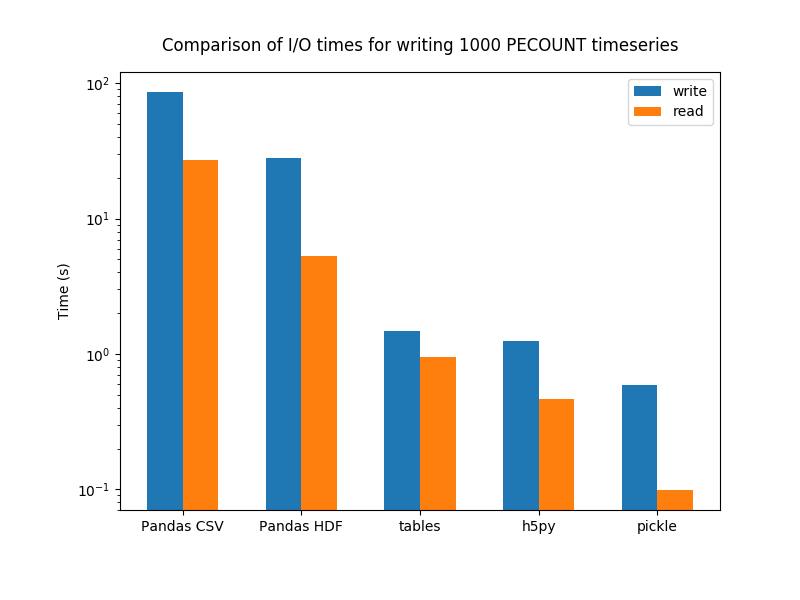

In [144]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(left=0.15, bottom=0.15)

ax.bar(np.arange(len(method)), write_time, width=0.3, label='write')
ax.bar(np.arange(len(method)) + 0.3, read_time, width=0.3, label='read')
ax.set_yscale('log')
ax.legend(loc=1)
ax.set_ylabel("Time (s)")
ax.set_xticks(np.arange(len(method)) + 0.15)
ax.set_xticklabels(method)
ax.set_title("Comparison of I/O times for writing 1000 PECOUNT timeseries", fontsize=12, pad=15)

fig.savefig('temp.png', dpi=150);